In [407]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('notebook')
import scipy.stats as stats
from functools import reduce 
%matplotlib inline

In [408]:
# Import Relevant CSV Files
pop = pd.read_csv('data/population/population_total.csv')
cases = pd.read_csv('data/Originals/reported_indigenous_confirmed_cases.csv')
m_deaths = pd.read_csv('data/Originals/reported_deaths.csv')
resistance = pd.read_csv('data/Originals/insecticide_resistance.csv')
net_dist = pd.read_csv('data/Originals/amf_distributions.csv') 
temp = pd.read_csv('data/temperature/temp.csv')
rain = pd.read_csv('data/rain/rain.csv')
incidence = pd.read_csv('data/incidence/incidence.csv')

# Data Wrangling and EDA

## Reported Cases of Diagnosed Malaria

In [409]:
cases.columns

Index(['GHO (CODE)', 'GHO (DISPLAY)', 'GHO (URL)', 'PUBLISHSTATE (CODE)',
       'PUBLISHSTATE (DISPLAY)', 'PUBLISHSTATE (URL)', 'YEAR (CODE)',
       'YEAR (DISPLAY)', 'YEAR (URL)', 'REGION (CODE)', 'REGION (DISPLAY)',
       'REGION (URL)', 'COUNTRY (CODE)', 'COUNTRY (DISPLAY)', 'COUNTRY (URL)',
       'Display Value', 'Numeric', 'Low', 'High', 'Comments'],
      dtype='object')

In [410]:
cases = cases.rename(columns={'YEAR (CODE)':'year',
                    'REGION (CODE)':'region',
                    'COUNTRY (CODE)':'country_code',
                    'REGION (CODE)' : 'region',
                     'COUNTRY (DISPLAY)' : 'country_name',         
                    'Numeric':'reported_cases'})

cases = cases[['year', 'country_code','reported_cases', 'region']]

print('Years from:', '', cases['year'].min(), '-', cases['year'].max())
print(cases.isnull().any())
print(cases.head())
print(cases.info())

Years from:  2000 - 2014
year              False
country_code      False
reported_cases    False
region            False
dtype: bool
   year country_code  reported_cases region
0  2001          EGY             0.0    EMR
1  2003          EGY             0.0    EMR
2  2013          IRQ             0.0    EMR
3  2004          OMN             0.0    EMR
4  2012          SYR             0.0    EMR
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 4 columns):
year              1392 non-null int64
country_code      1392 non-null object
reported_cases    1392 non-null float64
region            1392 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 43.6+ KB
None


In [411]:
cases_sum = cases.groupby('year').sum()

In [412]:
cases_sum.head(10)

,reported_cases
year,
2000,7782615.8
2001,6929445.2
2002,7926897.5
2003,10673614.1
2004,10687696.0
2005,12181704.0
2006,12023237.0
2007,13769700.0
2008,14161401.0


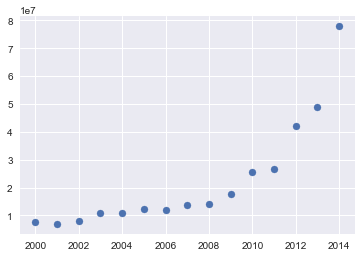

In [413]:
plt.scatter(cases_sum.index, cases_sum['reported_cases'])

In [414]:
cases_by_region = cases.groupby(['region', 'year']).sum()
cases_by_region.head()


reported_cases
region year                
AFR    2000       1383633.8
       2001       2356596.2
       2002       3290639.5
       2003       5492411.1
       2004       5881545.0

In [415]:
regions = list(cases['region'].unique())
regions = sorted(regions, key=str.lower)

# cases_by_region = cases_by_region.unstack(level=0)
# cases_by_region.columns = cases_by_region.columns.droplevel(1)
# cases_by_region.columns = regions
cases_by_region = cases_by_region.reset_index()
cases_by_region.head()


,region,year,reported_cases
0,AFR,2000,1383633.8
1,AFR,2001,2356596.2
2,AFR,2002,3290639.5
3,AFR,2003,5492411.1
4,AFR,2004,5881545.0


In [416]:
# cases_by_region = pd.melt(cases_by_region, id_vars='year', var_name='region', value_vars=regions, value_name='reported_cases')

In [417]:
# cases_by_region.head()


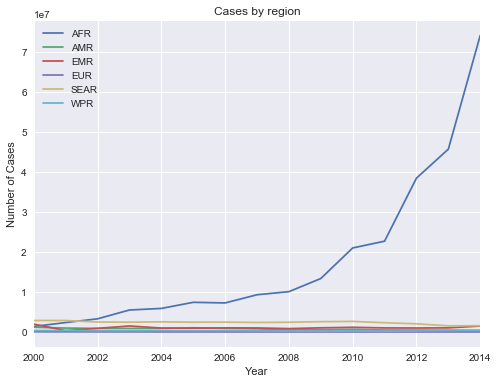

In [418]:
ax = None
for group in cases_by_region.groupby('region'):
    ax = group[1].plot(x='year', y='reported_cases', figsize=(8,6), ax=ax)
ax.legend(regions)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')
ax.set_title('Cases by region')
plt.show()

In [419]:
africa = cases[(cases['region'] == 'AFR')]
africa_by_country = africa.groupby(['country_code', 'year']).sum()
africa_by_country = africa_by_country.reset_index()
africa_by_country.head()


,country_code,year,reported_cases
0,AGO,2005,889572.0
1,AGO,2006,1082398.0
2,AGO,2007,1533485.0
3,AGO,2008,1377992.0
4,AGO,2009,1573422.0


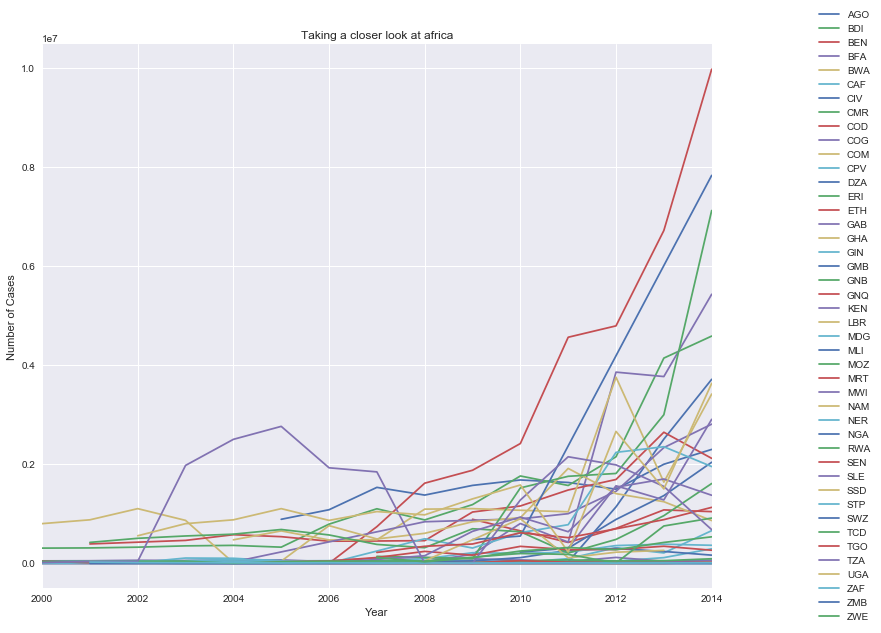

In [420]:
case_countries = africa_by_country.country_code.unique()
ax1 = None
for group in africa_by_country.groupby('country_code'):
    ax1 = group[1].plot(x='year', y='reported_cases', figsize=(12,10), ax=ax1)
ax1.legend(case_countries, loc='center right', bbox_to_anchor=(1.25, 0.5))
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Cases')
ax1.set_title('Taking a closer look at africa')
plt.show()

In [421]:
AFR2014 = africa_by_country[(africa_by_country['year'] == 2014)]
print(AFR2014.sort_values(["reported_cases"], ascending=False).head(5))

    country_code  year  reported_cases
93           COD  2014       9968983.0
330          NGA  2014       7826954.0
289          MOZ  2014       7117648.0
40           BFA  2014       5428655.0
24           BDI  2014       4585273.0


## Mortality Data

In [422]:
m_deaths.columns

Index(['GHO (CODE)', 'GHO (DISPLAY)', 'GHO (URL)', 'PUBLISHSTATE (CODE)',
       'PUBLISHSTATE (DISPLAY)', 'PUBLISHSTATE (URL)', 'YEAR (CODE)',
       'YEAR (DISPLAY)', 'YEAR (URL)', 'REGION (CODE)', 'REGION (DISPLAY)',
       'REGION (URL)', 'COUNTRY (CODE)', 'COUNTRY (DISPLAY)', 'COUNTRY (URL)',
       'Display Value', 'Numeric', 'Low', 'High', 'Comments'],
      dtype='object')

In [423]:
m_deaths = m_deaths.rename(columns={'YEAR (CODE)':'year',
                    'REGION (CODE)':'region',
                    'COUNTRY (CODE)':'country_code',
                    'Numeric':'reported_deaths'})
m_deaths = m_deaths[['year', 'country_code','reported_deaths', 'region']]

print('Years from:', '', m_deaths['year'].min(), '-', m_deaths['year'].max())
print(m_deaths.isnull().any())
print(m_deaths.head())
print(m_deaths.info())

Years from:  2000 - 2014
year               False
country_code       False
reported_deaths    False
region             False
dtype: bool
   year country_code  reported_deaths region
0  2008          DZA              0.0    AFR
1  2012          DZA              0.0    AFR
2  2014          DZA              0.0    AFR
3  2001          CPV              0.0    AFR
4  2013          CPV              0.0    AFR
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
year               1408 non-null int64
country_code       1408 non-null object
reported_deaths    1408 non-null float64
region             1408 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 44.1+ KB
None


In [424]:
deaths_sum = m_deaths.groupby('year').sum()
deaths_sum.head(10)

,reported_deaths
year,
2000,88222.0
2001,112615.0
2002,119338.0
2003,161581.0
2004,122025.0
2005,144366.0
2006,144514.0
2007,108011.0
2008,109122.0


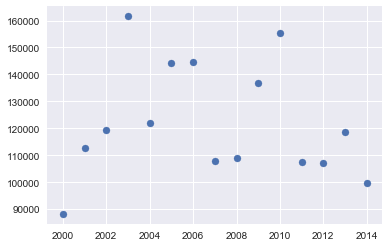

In [425]:
plt.scatter(deaths_sum.index, deaths_sum['reported_deaths'])

In [426]:
deaths_by_region = m_deaths.groupby(['region', 'year']).sum()
deaths_by_region.head()

reported_deaths
region year                 
AFR    2000          77642.0
       2001         103036.0
       2002         110516.0
       2003         152657.0
       2004         114045.0

In [427]:
regions_d = list(m_deaths['region'].unique())
regions_d = sorted(regions_d, key=str.lower)

# deaths_by_region = deaths_by_region.unstack(level=0)
# deaths_by_region.columns = deaths_by_region.columns.droplevel(1)
# deaths_by_region.columns = regions_d
deaths_by_region = deaths_by_region.reset_index()
deaths_by_region.head()

,region,year,reported_deaths
0,AFR,2000,77642.0
1,AFR,2001,103036.0
2,AFR,2002,110516.0
3,AFR,2003,152657.0
4,AFR,2004,114045.0


In [428]:
# deaths_by_region = pd.melt(deaths_by_region, id_vars='year', var_name='region', value_vars=regions, value_name='reported_deaths')

In [429]:
# deaths_by_region.head()

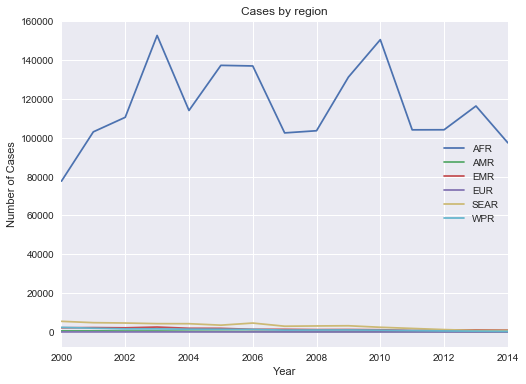

In [430]:
ax = None
for group in deaths_by_region.groupby('region'):
    ax = group[1].plot(x='year', y='reported_deaths', figsize=(8,6), ax=ax)
ax.legend(regions)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')
ax.set_title('Cases by region')
plt.show()

In [431]:
africa_deaths = m_deaths[(m_deaths['region'] == 'AFR')]
africa_deaths_by_country = africa_deaths.groupby(['country_code', 'year']).sum()
africa_deaths_by_country = africa_deaths_by_country.reset_index()
africa_deaths_by_country.head()

,country_code,year,reported_deaths
0,AGO,2000,9510.0
1,AGO,2001,9473.0
2,AGO,2002,14434.0
3,AGO,2003,38598.0
4,AGO,2004,12459.0


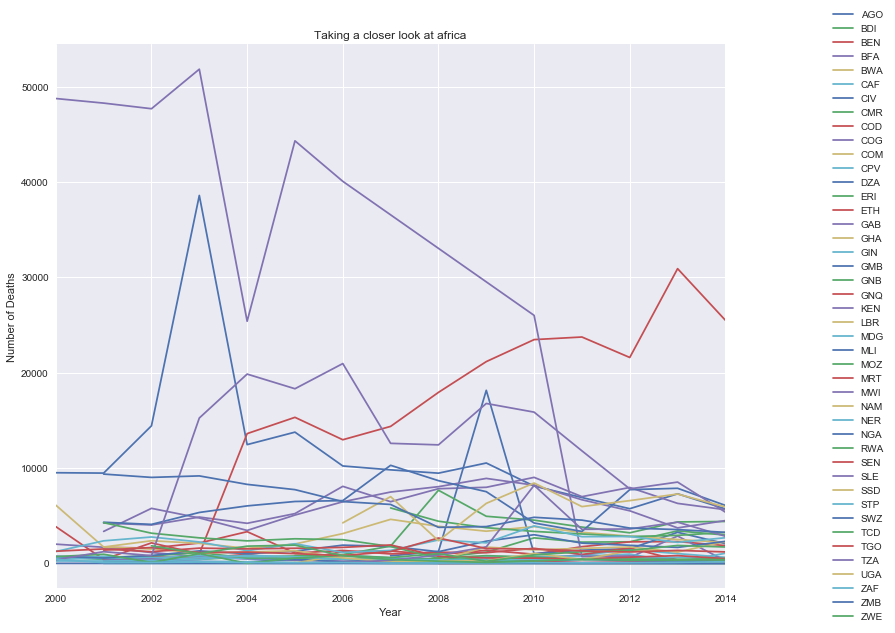

In [432]:
ax1 = None
for group in africa_deaths_by_country.groupby('country_code'):
    ax1 = group[1].plot(x='year', y='reported_deaths', figsize=(12,10), ax=ax1)
ax1.legend(case_countries, loc='center right', bbox_to_anchor=(1.25, 0.5))
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Deaths')
ax1.set_title('Taking a closer look at africa')
plt.show()

In [433]:
AFR2014_deaths = africa_deaths_by_country[(africa_deaths_by_country['year'] == 2014)]
print(AFR2014_deaths.sort_values(['reported_deaths'], ascending=False).head(5))

    country_code  year  reported_deaths
118          COD  2014          25502.0
388          NGA  2014           6082.0
519          UGA  2014           5921.0
14           AGO  2014           5714.0
57           BFA  2014           5632.0


## Treatment Resistance Data

In [434]:
resistance.columns

Index(['GHO (CODE)', 'GHO (DISPLAY)', 'GHO (URL)', 'PUBLISHSTATE (CODE)',
       'PUBLISHSTATE (DISPLAY)', 'PUBLISHSTATE (URL)', 'YEAR (CODE)',
       'YEAR (DISPLAY)', 'YEAR (URL)', 'REGION (CODE)', 'REGION (DISPLAY)',
       'REGION (URL)', 'COUNTRY (CODE)', 'COUNTRY (DISPLAY)', 'COUNTRY (URL)',
       'Display Value', 'Numeric', 'Low', 'High', 'Comments'],
      dtype='object')

In [435]:
resistance = resistance.rename(columns={'YEAR (CODE)':'year',
                                         'REGION (CODE)':'region',
                                          'COUNTRY (CODE)':'country_code',
                                           'Display Value':'tx_resistance'})
resistance = resistance[['year', 'country_code','tx_resistance']]

print('Years from:', '', resistance['year'].min(), '-', resistance['year'].max())


print(resistance.isnull().any())
print(resistance.head())
print(resistance.info())


Years from:  2000 - 2015
year             False
country_code     False
tx_resistance    False
dtype: bool
   year country_code tx_resistance
0  2012          BGD           Yes
1  2012          BEN           Yes
2  2011          GHA           Yes
3  2009          KEN           Yes
4  2009          TGO           Yes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6180 entries, 0 to 6179
Data columns (total 3 columns):
year             6180 non-null int64
country_code     6180 non-null object
tx_resistance    6180 non-null object
dtypes: int64(1), object(2)
memory usage: 144.9+ KB
None


## Insect Net Distribution Data

In [436]:
net_dist.columns

Index(['number_llins', 'location', 'country', 'when', 'by_whom',
       'country_code'],
      dtype='object')

In [437]:
net_dist = net_dist.rename(columns={'number_llins':'number_nets'})
net_dist = net_dist[['when', 'number_nets', 'country_code']]


# Parse out year and add year code column to the 'net_dist'        
net_dist['year'] = '20'+net_dist['when'].str[-2:]
net_year = pd.to_numeric(net_dist['year'], errors='coerce')
net_dist['year'] = net_year


In [438]:
# no need to retain the original column
net_dist = net_dist.drop(['when'], axis=1)


In [439]:
print('Years from:', '', net_dist['year'].min(), '-', net_dist['year'].max())

print(net_dist.isnull().any())
print(net_dist.head())
print(net_dist.info())

Years from:  2006 - 2019
number_nets     False
country_code     True
year            False
dtype: bool
   number_nets country_code  year
0         3000          KEN  2006
1         3000          MWI  2006
2         3000          NAM  2006
3         2000          RWA  2006
4         2000          UGA  2006
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 3 columns):
number_nets     167 non-null int64
country_code    163 non-null object
year            167 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.0+ KB
None


Of note at this point there are differences in the years with complete data i.e. The years for the 'net_dist' are from 2006-2019 and the years for 'resistance' cover 2000-2014, and the population data covers 1950-2050. Given this I will restrict analysis to the years 2000-2014. This will give the greatest density across the most fields. As for the dates yet to arrive, I will assume they are predictive and not error, either way they will not be used. Following this the correllations for the net use and resistance data will both have less power than those of the other factors, but I believe can still yeild some useful insights. 

## Population Data

In [440]:
# This population data was pulled from the world bank indicators API
pop.columns

Index(['country_name', 'country_code', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014'],
      dtype='object')

In [441]:
pop = pop.melt(id_vars=['country_name', 'country_code'], var_name='year', value_vars=['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'], value_name='population')


In [442]:
pop['year'] = pd.to_numeric(pop['year'], errors='coerce', downcast='integer')



In [443]:
print(pop.info())
print(pop.head())
print(pop.isnull().any())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 4 columns):
country_name    1605 non-null object
country_code    1605 non-null object
year            1605 non-null int16
population      1602 non-null float64
dtypes: float64(1), int16(1), object(2)
memory usage: 40.8+ KB
None
  country_name country_code  year    population
0   Bangladesh          BGD  2000  1.315812e+08
1      Bolivia          BOL  2000  8.339512e+06
2        China          CHN  2000  1.262645e+09
3     Honduras          HND  2000  6.524283e+06
4        Haiti          HTI  2000  8.549200e+06
country_name    False
country_code    False
year            False
population       True
dtype: bool


In [444]:
pop[pop.isnull().any(axis=1)]

,country_name,country_code,year,population
1368,Eritrea,ERI,2012,NaN
1475,Eritrea,ERI,2013,NaN
1582,Eritrea,ERI,2014,NaN


Given  that these are the only 3 values missing from this portion of the data it is unlikely that 3 years from a single country will throw off the correlation much. These values may be obtained from an alternate scource or extrapolated at a later time if necessary.

In [445]:
pop = pop.drop('country_name', axis=1)


# Temperature Data

In [446]:
# This data was pulled from the world bank climate API

temp.columns

Index(['tas', '\tYear', ' Month', ' Country'], dtype='object')

In [447]:
# Altering column labels for preference, clarity, and ease of use
temp = temp.rename(columns={'\tYear' : 'year',
                            ' Country' : 'country_code',
                            'tas' : 'temperature',
                            ' Month' : 'month'})
# making a list for reference of the list of countries
countries = list(temp.country_code.unique())
countries = sorted(countries, key=str.lower)

temp.columns

Index(['temperature', 'year', 'month', 'country_code'], dtype='object')

In [448]:
# Pivoting the df and taking the average of each year for each country
temp = temp.pivot_table(index=['country_code', 'year'], values=['temperature'])
temp = temp.pivot_table(index=['year'], columns='country_code', aggfunc='mean')

# Returning the df to a flate file with proper column labels
temp.columns = temp.columns.droplevel(1)
temp.columns = countries
temp = temp.reset_index()
temp.head()


,year,ABW,AGO,ALB,AND,ANT,ARE,ARG,ATG,AUS,...,TLS,TON,TUR,TUV,URY,VEN,VGB,WSM,XRK,ZAF
0,1901,27.642242,21.455058,10.997927,10.786337,27.591533,27.060492,14.789754,25.221792,21.468767,...,25.331158,24.513042,11.259894,28.117592,16.805533,25.304417,25.121258,26.389900,8.306526,16.742045
1,1902,27.510883,21.455550,11.241467,10.662564,27.446775,26.546458,14.449022,25.012475,21.487850,...,25.327908,24.514725,10.639450,28.117592,17.042166,25.265658,24.819367,26.392217,8.333778,16.635380
2,1903,27.618575,21.599133,11.380389,10.395305,27.559650,25.929717,14.115068,25.188767,21.020500,...,25.487983,24.406133,10.261870,28.117592,16.851150,25.299042,25.065408,26.156533,8.825191,16.606524
3,1904,27.399308,21.426175,11.385637,10.682016,27.319133,26.162242,14.362343,24.802750,20.873142,...,25.159600,24.276542,10.257519,28.117592,16.619800,25.224125,24.542483,25.910533,8.705065,16.559092
4,1905,27.540717,21.490208,11.162694,10.333673,27.477108,26.166942,14.022728,25.044050,21.039092,...,25.539017,24.323758,10.504210,28.117592,16.440438,25.262492,24.859950,25.986725,8.536213,16.775360


In [449]:
# Melting the df into a format consistent for merging
temp = pd.melt(temp, id_vars='year', var_name='country_code', value_vars=countries, value_name='temperature')

print(temp.head())
print(temp.isnull().any())

   year country_code  temperature
0  1901          ABW    27.642242
1  1902          ABW    27.510883
2  1903          ABW    27.618575
3  1904          ABW    27.399308
4  1905          ABW    27.540717
year            False
country_code    False
temperature     False
dtype: bool


Given that we have 12 monthly values per country per year, for the purposes of this project we will be using the average for the entire year as a representative value for each country in each year. 

# Rainfall

In [450]:
rain.columns

Index(['\tYear', ' Country', ' Month', 'pr'], dtype='object')

In [451]:
# Altering column labels for preference, clarity, and ease of use
rain = rain.rename(columns={'\tYear' : 'year',
                            ' Country' : 'country_code',
                            'pr' : 'rainfall',
                            ' Month' : 'month'})
rain.columns

Index(['year', 'country_code', 'month', 'rainfall'], dtype='object')

In [452]:
rain.head()

,year,country_code,month,rainfall
0,1901,HUN,1,33.2111
1,1901,HUN,2,23.1772
2,1901,HUN,3,56.7961
3,1901,HUN,4,44.8803
4,1901,HUN,5,38.4405


In [453]:
# making a list for reference of the list of countries
countries_rain = list(rain.country_code.unique())
countries_rain = sorted(countries_rain, key=str.lower)


In [454]:
# Pivoting the df and taking the average of each year for each country
rain = rain.pivot_table(index=['country_code', 'year'], values=['rainfall'])
rain = rain.pivot_table(index=['year'], columns='country_code', aggfunc='mean')

# Returning the df to a flate file with proper column labels
rain.columns = rain.columns.droplevel(1)
rain.columns = countries_rain
rain = rain.reset_index()
rain.head()

,year,ABW,AFG,AGO,AIA,ALB,AND,ANT,ARE,ARG,...,UGA,UKR,URY,VEN,VGB,WLF,XRK,ZAF,ZAR,ZMB
0,1901,66.212208,22.003305,78.829634,165.699658,109.532408,72.438942,57.992458,6.088290,34.306833,...,79.557275,44.055075,74.235625,159.076375,235.662742,246.685917,88.051583,48.265558,124.895383,81.119453
1,1902,63.277825,19.309642,80.638373,145.714400,91.475967,64.681767,53.068872,2.941165,40.299917,...,107.483142,44.113995,89.882358,156.658808,196.272708,243.730583,68.853592,34.905365,128.504792,85.028674
2,1903,66.125392,28.250687,86.407364,136.778750,77.561858,58.670862,57.062367,4.714039,44.477725,...,110.209158,41.334672,99.643742,161.321958,176.185117,253.022083,62.789842,28.310880,131.223900,74.106387
3,1904,76.067375,24.889266,73.780345,142.704067,83.001250,47.820001,68.335317,4.125526,45.638217,...,99.307917,35.507442,95.443992,167.353417,189.685750,253.791083,64.266567,35.808872,126.369942,83.024439
4,1905,68.831567,23.841139,75.149998,148.186992,77.295800,68.907067,59.624433,8.215321,42.698383,...,100.751333,47.263400,86.885450,161.105917,203.374967,239.886667,69.618625,35.985650,126.628408,74.191419


In [455]:
# Melting the df into a format consistent for merging
rain = pd.melt(rain, id_vars='year', var_name='country_code', value_vars=countries_rain, value_name='rainfall')

print(rain.head())
print(rain.isnull().any())

   year country_code   rainfall
0  1901          ABW  66.212208
1  1902          ABW  63.277825
2  1903          ABW  66.125392
3  1904          ABW  76.067375
4  1905          ABW  68.831567
year            False
country_code    False
rainfall        False
dtype: bool


## Incidence data

In [456]:
incidence.columns

Index(['country_name', 'country_code', 'year', 'incidence'], dtype='object')

In [457]:
incidence.head()

,country_name,country_code,year,incidence
0,Afghanistan,AFG,1962,640
1,Afghanistan,AFG,1963,923
2,Afghanistan,AFG,1964,2658
3,Afghanistan,AFG,1965,2112
4,Afghanistan,AFG,1966,2551


In [458]:
incidence = incidence.drop('country_name', axis=1)

In [459]:
incidence['incidence'] = pd.to_numeric(incidence['incidence'], errors='coerce')
incidence = incidence.dropna(how='any')

In [460]:
incidence.to_csv(path_or_buf='inci.csv')
incidence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3695 entries, 0 to 5367
Data columns (total 3 columns):
country_code    3695 non-null object
year            3695 non-null int64
incidence       3695 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 115.5+ KB


# Merging for A/B testing

In [461]:
merge_AB = [cases, m_deaths, resistance, net_dist]

In [462]:
df_AB = reduce(lambda  left,right: pd.merge(left,right,on=['country_code', 'year'], how='outer'), merge_AB)
df_AB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6623 entries, 0 to 6622
Data columns (total 8 columns):
year               6623 non-null int64
country_code       6619 non-null object
reported_cases     5368 non-null float64
region_x           5368 non-null object
reported_deaths    5571 non-null float64
region_y           5571 non-null object
tx_resistance      6472 non-null object
number_nets        620 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 465.7+ KB


In [463]:
df_AB = df_AB[(df_AB.year >= 2000) & (df_AB.year <= 2014)]
df_AB.dropna(inplace=True)
df_AB.drop_duplicates(inplace=True)

In [464]:
print('Number of years:', '', df_AB['year'].nunique())
print('Years from:', '', df_AB['year'].min(), '-', df_AB['year'].max())
print('Number of countries:', '', df_AB['country_code'].nunique())
print(df_AB.isnull().any())
print(df_AB.info())


Number of years:  9
Years from:  2006 - 2014
Number of countries:  31
year               False
country_code       False
reported_cases     False
region_x           False
reported_deaths    False
region_y           False
tx_resistance      False
number_nets        False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 208 to 5357
Data columns (total 8 columns):
year               162 non-null int64
country_code       162 non-null object
reported_cases     162 non-null float64
region_x           162 non-null object
reported_deaths    162 non-null float64
region_y           162 non-null object
tx_resistance      162 non-null object
number_nets        162 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 11.4+ KB
None


In [465]:
df_AB.drop(['region_y'], axis=1, inplace=True)
df_AB.head(10)

,year,country_code,reported_cases,region_x,reported_deaths,tx_resistance,number_nets
208,2006,STP,5146.0,AFR,26.0,Not tested/reported,6000.0
364,2006,HTI,32739.0,AMR,32.0,Not tested/reported,8000.0
472,2007,COG,103213.0,AFR,113.0,Not tested/reported,10000.0
552,2007,GHA,476484.0,AFR,4622.0,Yes,5200.0
553,2007,GHA,476484.0,AFR,4622.0,Yes,10000.0
558,2007,GHA,476484.0,AFR,4622.0,No,5200.0
559,2007,GHA,476484.0,AFR,4622.0,No,10000.0
592,2010,SLE,934028.0,AFR,8188.0,No,10560.0
612,2010,UGA,1581160.0,AFR,8431.0,Not tested/reported,450.0
613,2010,UGA,1581160.0,AFR,8431.0,Not tested/reported,250.0


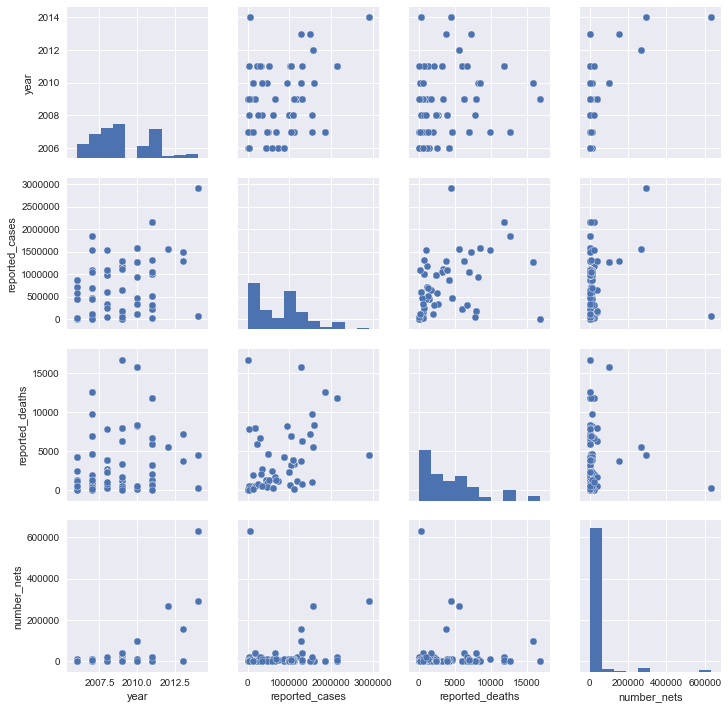

In [466]:
sns.pairplot(df_AB);

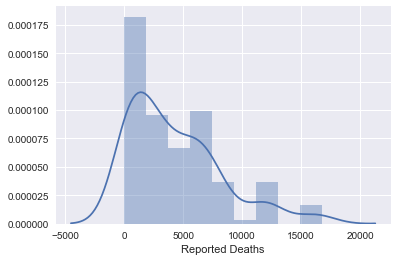

In [467]:
sns.distplot(df_AB['reported_deaths'], axlabel='Reported Deaths');

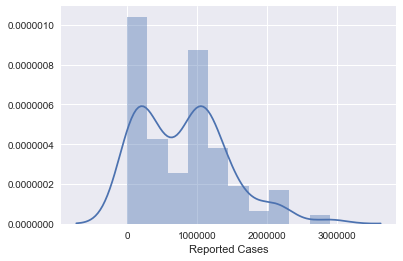

In [468]:
sns.distplot(df_AB['reported_cases'], axlabel='Reported Cases');

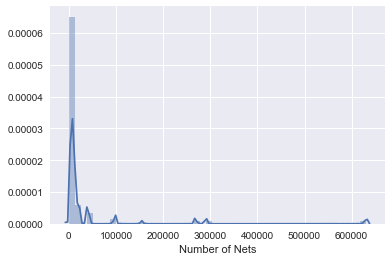

In [469]:
sns.distplot(df_AB['number_nets'], axlabel='Number of Nets');

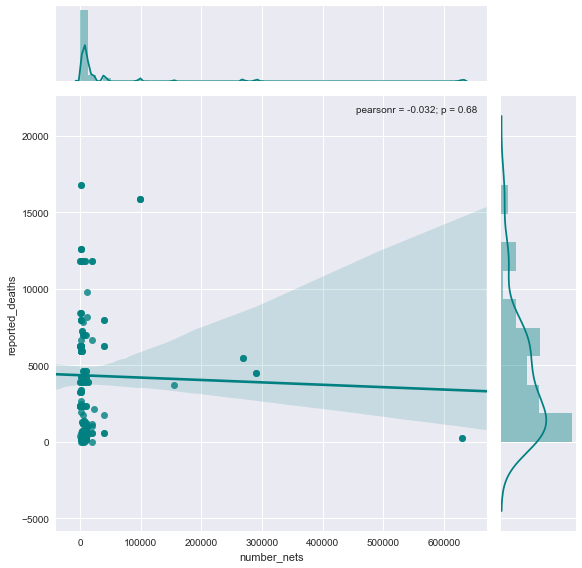

In [470]:
sns.jointplot(x='number_nets', y="reported_deaths", data=df_AB, kind='reg', color='teal', size=8);

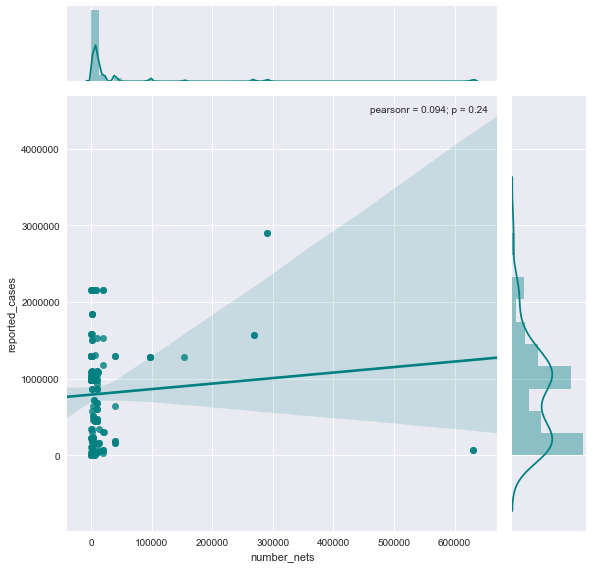

In [471]:
sns.jointplot(x='number_nets', y="reported_cases", data=df_AB, kind='reg', color='teal', size=8);

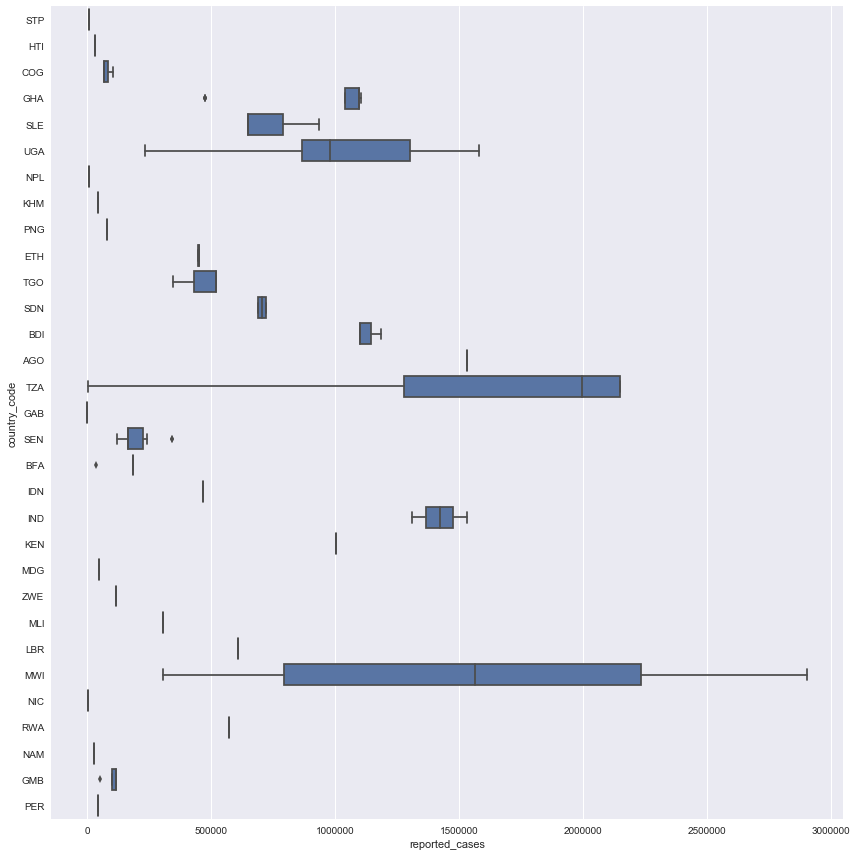

In [472]:
s = sns.FacetGrid(df_AB, size=12, aspect=1.0)
s.map(sns.boxplot, "reported_cases", "country_code");

## Merging for correlation

In [473]:
merge_TRI = [temp, rain, incidence]

In [474]:
df_TRI = reduce(lambda  left,right: pd.merge(left,right,on=['country_code', 'year'], how='outer'), merge_TRI)
df_TRI.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21373 entries, 0 to 21372
Data columns (total 5 columns):
year            21373 non-null int64
country_code    21373 non-null object
temperature     15065 non-null float64
rainfall        19895 non-null float64
incidence       3695 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1001.9+ KB


In [475]:
df_TRI.head(10)

,year,country_code,temperature,rainfall,incidence
0,1901,ABW,27.642242,66.212208,NaN
1,1902,ABW,27.510883,63.277825,NaN
2,1903,ABW,27.618575,66.125392,NaN
3,1904,ABW,27.399308,76.067375,NaN
4,1905,ABW,27.540717,68.831567,NaN
5,1906,ABW,27.497617,61.726025,NaN
6,1907,ABW,27.389675,61.635600,NaN
7,1908,ABW,27.562575,66.959417,NaN
8,1909,ABW,27.408200,61.950400,NaN
9,1910,ABW,27.355658,63.821708,NaN


In [476]:
df_TRI = df_TRI[(df_TRI['incidence'] > 0)]

In [477]:
df_TRI = df_TRI.dropna(how='any')

In [478]:

print('Number of years:', '', df_TRI['year'].nunique())
print('Years from:', '', df_TRI['year'].min(), '-', df_TRI['year'].max())
print('Number of countries:', '', df_TRI['country_code'].nunique())
print(df_TRI.isnull().any())
print(df_TRI.info())
# df_TRI.to_csv(path_or_buf='df.csv')

Number of years:  40
Years from:  1962 - 2015
Number of countries:  73
year            False
country_code    False
temperature     False
rainfall        False
incidence       False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 176 to 15064
Data columns (total 5 columns):
year            1928 non-null int64
country_code    1928 non-null object
temperature     1928 non-null float64
rainfall        1928 non-null float64
incidence       1928 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 90.4+ KB
None


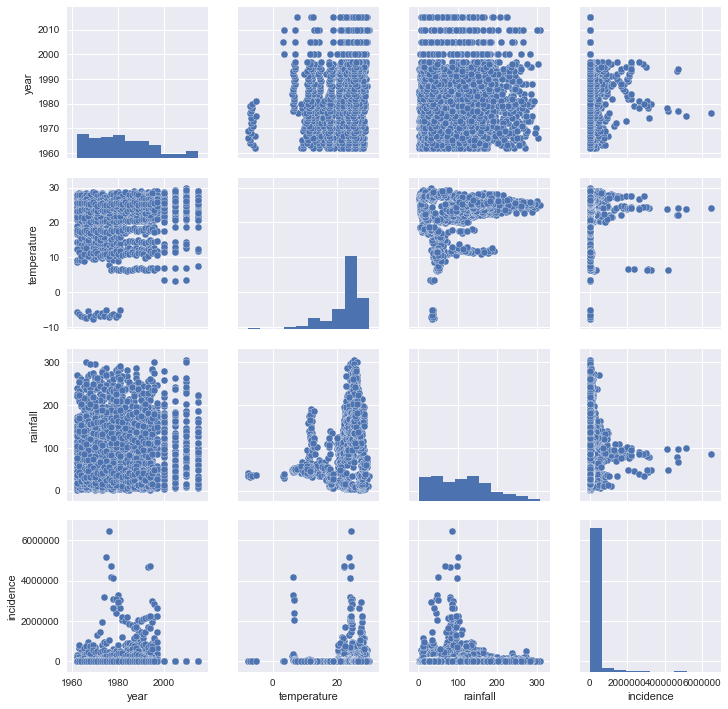

In [479]:
sns.pairplot(df_TRI);

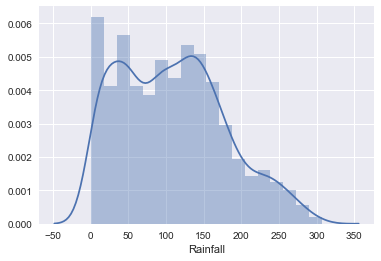

In [480]:
sns.distplot(df_TRI['rainfall'], axlabel='Rainfall');

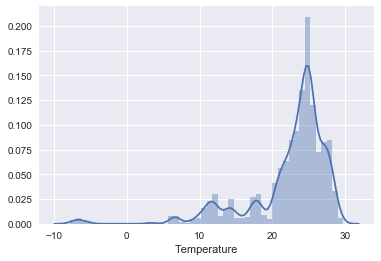

In [481]:
sns.distplot(df_TRI['temperature'], axlabel='Temperature');

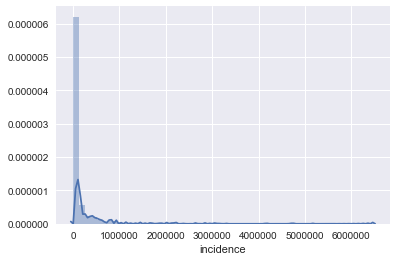

In [482]:
sns.distplot(df_TRI['incidence'], axlabel='incidence');

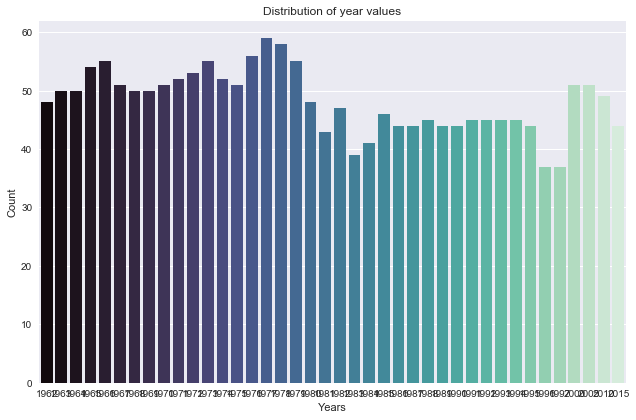

In [483]:
sns.set_context('notebook')
# Distribution of years
sns.factorplot(x="year", data=df_TRI, kind="count",
                   palette='mako', size=6, aspect=1.5)

plt.title('Distribution of year values')
plt.ylabel('Count')
plt.xlabel('Years')
plt.tight_layout()
plt.show()

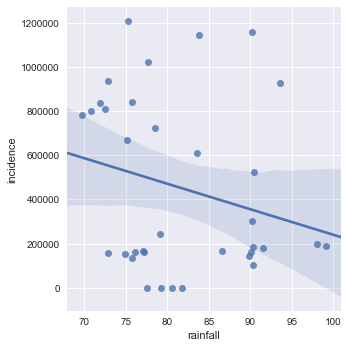

In [484]:
df_AGO = df_TRI[(df_TRI['country_code'] == 'AGO')]
df_AGO.head()
sns.lmplot(x="rainfall", y="incidence", data=df_AGO);


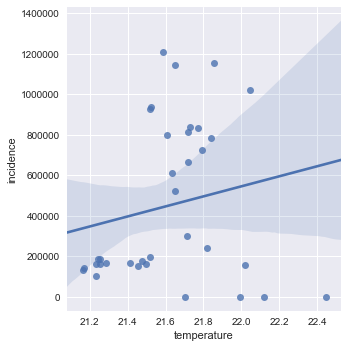

In [485]:
df_AGO = df_TRI[(df_TRI['country_code'] == 'AGO')]
df_AGO.head()
sns.lmplot(x="temperature", y="incidence", data=df_AGO);
